# Set up a regional MOM6 run within CESM framework (with CRR)

Background: The independent, strong, package that sets up a regional MOM run is the regional-mom6 (RM6) package. There's a few things we wanted to add that are specific to the CESM, because we are running MOM inside the CESM. There's also new ways we want to gather grids that uses files on the NCAR glade file system.

Motivation: There's a few different motivations. Since we have some, almost, "NCAR-specific" things, we don't want to put those into the *independent* package, RM6. In the spirit of that, Ashley developed an additional module/package called regional-casegen to setup the CESM side of things that takes in input from the RM6 workflow. Then, we needed to incorporate the new way of gathering grids. That's another module. This forces or speaks for the idea of a framework to use all the modules in this workflow. Having an overall umbrella that can work with multiple packages without fiddling with RM6 is an attractive proposition.

Description: The framework here is called Crocodile Regional Ruckus (CRR). It, currently, holds four modules grid_gen, boundary_conditions, RM6, and regional-casegen. It's a lightweight package that ties together each part of the process into one package. A large part of the code is wrapping RM6. The major difference between the two is that CRR brings in the NCAR and derechp specific dependencies. CRR also uses explicit function definitions, so every function is completely standalone. This is a style change from regional mom6, which relies heavily on variables defined in the class object. Based on what style the user prefers, they can use RM6 to work through a workflow of setting up a regional case with CRR function calls at either end for grid generation and cesm setup, OR they can use just CRR to explicity call a function or two they require all the way up to the entire workflow. See a visualization: https://drive.google.com/file/d/1Y1FQnT741pcLVVOOl5qS1JphsuiXnVLv/view?usp=sharing

Getting Familiar (Installation): Going with this flow, there are two demos to get used to the CRR. One is a "minimal_demo" that uses CRR for grid generation and regional casegen, but still majority uses RM6. It copies almost directly from the RM6 demo to show how little of a change it can be. The other demo is a "with_CRR" demo that uses CRR for everything. That still means a majority use of RM6, but just under the hood.

Since CRR is derecho specific, we can add it to the python module search path from my dir and just use it. For the environment, on derecho, this path can work: /glade/work/manishrv/conda-envs/vroom_clean_env

# SECTION 1: Setup up you MOM6 regional experiment

This follows the normal workflow, copied from the `reanalysis_forced.ipynb` demo of [regional-mom6](https://github.com/COSIMA/regional-mom6/) but modified for a domain around Hawaii. See the documentation of the package for details and documentation

In [1]:
import os
from pathlib import Path
import sys

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '/glade/u/home/manishrv/documents/nwa12_0.1/regional_mom_workflows/crr')
import crocodileregionalruckus as crr


## Step 1: Initialize our regional package, and define any variables we want to store (Choose domain)
One of the differences between CRR and RMOM6 is *supposed* to be that CRR functions for setting up a regional MOM6 run have explicit arguments. That means that initialization of the crr object doesn't have to have any arguments - OR it can have just as many as RMOM6. It's up to the user. They don't do anything intrinsically.

In [3]:
expt_name = "pan-demo-all-crr"

latitude_extent = [6, 12]
longitude_extent = [-86, -77]
resolution = 0.5
date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"]

# Each of these arguments don't do anything, but can be used to pass in the necessary arguments to each function
crr_obj = crr.driver.crr_driver(expt_name = expt_name, latitude_extent = latitude_extent, longitude_extent = longitude_extent, resolution = resolution, date_range = date_range)

### Setup Output Directories

In [18]:


## Place where all your input files go 
input_dir = Path(f"/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/{expt_name}/")

## Directory where you'll run the experiment from
run_dir = Path(f"/glade/u/home/manishrv/documents/nwa12_0.1/mom_run/{expt_name}/")

crr_obj.setup_directories(mom_run_dir = run_dir, mom_input_dir = input_dir)

## Step 1.5: Grid Generation

In [5]:
# Create Hgrid
grid_gen_obj = crr_obj.grid_gen_obj
rect_hgrid = grid_gen_obj.create_rectangular_hgrid(latitude_extent = latitude_extent, longitude_extent = longitude_extent, resolution = resolution)
#subset_global_hgrid = grid_gen_obj.subset_global_hgrid(longitude_extent, latitude_extent)

# Create Vgrid
gen_vgrid = grid_gen_obj.create_vgrid(75,10, 5)

# Move desired hgrid, and vgrid to mom_input with the filenames that regional mom6 recognizes
rect_hgrid.to_netcdf(input_dir / "hgrid.nc")
gen_vgrid.to_netcdf(input_dir / "vcoord.nc")

## Step 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `mom6-regional` package that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

The function is called `get_glorys_rectangular` because the fully automated setup is only supported for domains with boundaries parallel to lines of longitude and latitude. To download more complex domain shapes you can call `rmom6.get_glorys_data` directly.

In [28]:
glorys_path = Path("/glade/work/manishrv/inputs_rm6/pan-demo-crr/")
crr_obj.get_glorys_rectangular(
    raw_boundaries_path=glorys_path,
    boundaries=["north", "south", "east", "west"],
)

script `get_glorys_data.sh` has been created at /glade/work/manishrv/inputs_rm6/pan-demo-crr.
 Run this script via bash to download the data from a terminal with internet access. 
You will need to enter your Copernicus Marine username and password.
If you don't have an account, make one here:
https://data.marine.copernicus.eu/register


## Step 4: Set up bathymetry with grid gen

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [6]:
bathymetry_path='/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/gebco/GEBCO_2024.nc'
min_depth = 5
hgrid = rect_hgrid
topo = grid_gen_obj.setup_bathymetry(input_dir =  input_dir,
                                              longitude_extent=longitude_extent, 
                                              latitude_extent = latitude_extent, 
                                              minimum_depth = min_depth,  
                                              bathymetry_path = bathymetry_path, 
                                              longitude_coordinate_name="lon", 
                                              latitude_coordinate_name="lat", 
                                              vertical_coordinate_name="elevation", 
                                              hgrid = hgrid)
# OR, once angled grids work inside of MOM6
# expt.bathymetry = grid_gen_obj.subset_global_topo(longitude_extent, latitude_extent)



# Export to MOM directory
temp = topo

Begin regridding bathymetry...

Original bathymetry size: 32.29 Mb
Regridded size: 0.01 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory /glade/u/home/manishrv/documents/nwa12_0.1/mom_input/pan-demo-all-crr via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... done.
setup bathy

### Check out your domain:

In [10]:
import matplotlib.pyplot as plt


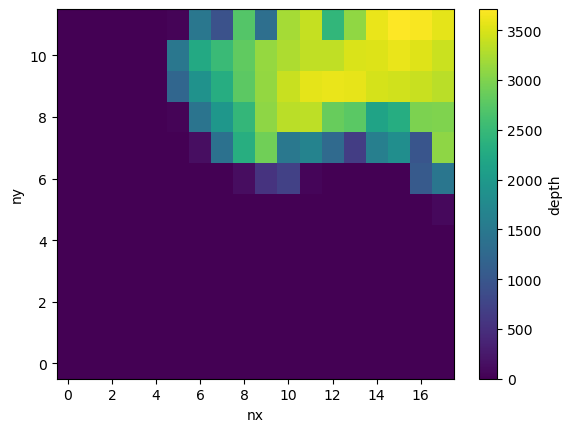

In [11]:
crr_obj.grid_gen_obj.topo.depth.plot()

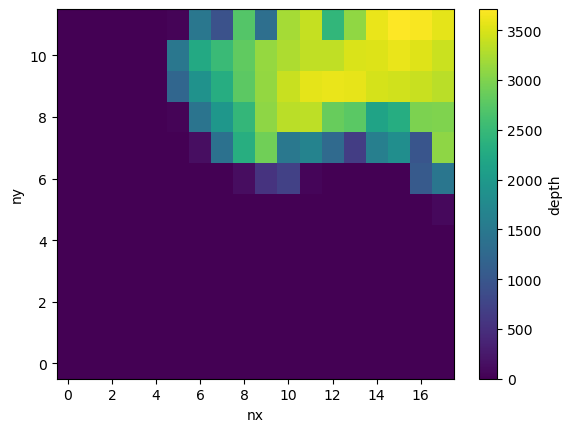

In [12]:
# Then mask out parts of the domain we don't want by selecting a point in the ocean domain we do want.
crr_obj.grid_gen_obj.topo = crr_obj.grid_gen_obj.mask_disconnected_ocean_areas(hgrid = crr_obj.grid_gen_obj.hgrid, topo = temp.depth[0], name_x_dim = "x", name_y_dim = "y", lat_pt = 10, lon_pt = -78)

# Save to EXPT input directory
crr_obj.grid_gen_obj.topo.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how for GLORYS, the horizontal dimensions are `latitude` and `longitude`, vs `xh`, `yh`, `xq`, `yq` for MOM6. This is because for an 'A' grid type tracers share the grid with velocities so there's no difference.

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update MOM_input to reflect this though so it knows how many segments to look for, and their orientations.

In [14]:
## TBD Explicit Mapping - 
glorys_path = Path(f"/glade/work/manishrv/inputs_rm6/pan-demo-crr" )

# Define a mapping from the GLORYS variables and dimensions to the MOM6 ones
ocean_varnames = {"time": "time",
                  "yh": "latitude",
                  "xh": "longitude",
                  "zl": "depth",
                  "eta": "zos",
                  "u": "uo",
                  "v": "vo",
                  "tracers": {"salt": "so", "temp": "thetao"}
                  }

# Set up the initial condition
crr_obj.boundary_conditions_obj.setup_initial_condition(crr_obj.grid_gen_obj.hgrid, crr_obj.grid_gen_obj.vgrid,
    glorys_path / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="A"
    )    

# Set up the four boundary conditions. Remember that in the glorys_path, we have four boundary files names north_unprocessed.nc etc. 
crr_obj.boundary_conditions_obj.setup_ocean_state_boundaries(crr_obj.grid_gen_obj.hgrid, crr_obj.grid_gen_obj.vgrid,crr_obj.date_range[0], 
        glorys_path,
        ocean_varnames,
        boundaries = ["south", "north", "west", "east"],
        arakawa_grid = "A"
        )

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 101.25 ms
Done.
[########################################] | 100% Completed | 101.20 ms
Done.
[########################################] | 100% Completed | 101.97 ms
Done.
[########################################] | 100% Completed | 101.95 ms
Done.


In [16]:
crr_obj.boundary_conditions_obj.setup_boundary_tides(crr_obj.grid_gen_obj.hgrid, crr_obj.date_range[0],["M2"],"/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data","tpxo9.v1.nc")


Processing south boundary...Done
Processing north boundary...Done
Processing west boundary...Done
Processing east boundary...Done


## Step 6: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and CPU layout.

To run MOM6 using the [payu infrastructure](https://github.com/payu-org/payu), provide the keyword argument `using_payu = True` to the `setup_run_directory` method and an example `config.yaml` file will be appear in the run directory. The `config.yaml` file needs to be modified manually to add the locations of executables, etc.

In [20]:
# Export all variables required to your MOM input dir

crr_obj.grid_gen_obj.export_files(crr_obj.mom_input_dir)
crr_obj.boundary_conditions_obj.export_files(crr_obj.mom_input_dir)



All files have been exported to /glade/u/home/manishrv/documents/nwa12_0.1/mom_input/pan-demo-all-crr
All files have been exported to /glade/u/home/manishrv/documents/nwa12_0.1/mom_input/pan-demo-all-crr


In [22]:
## TBD Explicit Mapping -  in Driver

# Add the MOM_input mappings we need

crr_obj.setup_run_directory(mom_input_dir=crr_obj.mom_input_dir, mom_run_dir=crr_obj.mom_run_dir,date_range = crr_obj.date_range,hgrid =  crr_obj.grid_gen_obj.hgrid,vgrid =  crr_obj.grid_gen_obj.vgrid,tidal_constituents=["M2"],   surface_forcing = "jra")

At least one of these is requiret to set up the experiment if you're running MOM6 standalone with the FMS coupler. 
If you're running within CESM, ignore this message.
Deleting indexed OBC keys from MOM_input_dict in case we have a different number of segments
Added MINIMUM_DEPTH to MOM_override with value {'value': 4.0, 'override': True, 'comment': None}
Added NK to MOM_override with value {'value': 75, 'override': True, 'comment': None}
Added OBC_NUMBER_OF_SEGMENTS to MOM_override with value {'value': 4, 'override': True, 'comment': None}
Added OBC_FREESLIP_VORTICITY to MOM_override with value {'value': 'False', 'override': True, 'comment': None}
Added OBC_FREESLIP_STRAIN to MOM_override with value {'value': 'False', 'override': True, 'comment': None}
Added OBC_COMPUTED_VORTICITY to MOM_override with value {'value': 'True', 'override': True, 'comment': None}
Added OBC_COMPUTED_STRAIN to MOM_override with value {'value': 'True', 'override': True, 'comment': None}
Added OBC_ZERO_BIHARM

In [ ]:
# Adjust any parameters in the input directory we need to change.



# SECTION 2: Create a blank CESM run

So far I've used Alper's [GUI](https://github.com/ESMCI/visualCaseGen?tab=readme-ov-file) branch of CESM. Clone respective branch of CESM and then run the generate case command. Below is the command I used to generate a global, MOM6 only run forced with JRA data atmosphere

`/glade/u/home/abarnes/cesm-runs/visualCaseGen/cesm2_3_beta17_gui/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res TL319_t232 --case /glade/u/home/manishrv/cases/pan-demo-all-crr --machine derecho --run-unsupported --project p93300012 --non-local`

In [23]:
# Save the path where the new CESM config lives, it's probably a bad idea to generate the CESM case from within crr/rm6
CESM_path = Path(f"/glade/u/home/manishrv/cases/pan-demo-all-crr")

# SECTION 3: Modify the CESM run to make it regional

In [24]:
## Regional CaseGen is part of crr

reg_cas_obj = crr.regional_casegen.cesm_tools.RegionalCaseGen()

## Only Change is to explicitly state what variables are needed
reg_cas_obj.setup_cesm_explicit(hgrid = crr_obj.grid_gen_obj.hgrid,
                                 CESMPath = CESM_path,
                                 project = "p93300612", 
                                 mom_input_dir=crr_obj.mom_input_dir, 
                                 mom_run_dir=crr_obj.mom_run_dir,
                                 date_range = crr_obj.date_range)

Copying input.nml, diag_table, MOM_input_and MOM_override to /glade/u/home/manishrv/cases/pan-demo-all-crr/SourceMods/src.mom
Adding NIGLOBAL = 18, NJGLOBAL = 12, and INPUTDIR = /glade/u/home/manishrv/documents/nwa12_0.1/mom_input/pan-demo-all-crr to MOM_override
Removing references to MOM_layout in input.nml
Add MOM_override to parameter_filename in input.nml
Move all of the forcing files out of the forcing directory to the main inputdir
Find and replace instances of forcing/ with nothing in the MOM_input file
Find and replace instances of forcing/ with nothing in the MOM_input file
Make ESMF grid and save to inputdir
Make xml changes. Setting OCN_NX=18, OCN_NY=12
MOM6_MEMORY_MODE=dynamic_symmetric
OCN_DOMAIN_MESH, ICE_DOMAIN_MESH, MASK_MESH, MASK_GRID, OCN_GRID, ICE_GRID =/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/pan-demo-all-crr/esmf_mesh.nc
RUN_REFDATE, RUN_STARTDATE = 2020-01-01
Make symlinks from the CESM directory to the mom input directory and the CESM run directory


Now hopefully doing the usual 

`./case.setup && ./case.build && ./case.submit` 

should at least run. Of course from here you'll have a lot of other things to fiddle around with to make it run *well!* 